# Battery model optimisation


### Required Modules
The following modules are used - these are chosen for simplicity in place of more elaborate optimisers

1. Pandas
2. Numpy
3. Scipy.optimize
4. Matplotlib.pyplot

In [1]:
#Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linprog
from scipy.optimize import minimize

### Battery

Create a class to hold the battery information - this is little more than a dictionary with capacity to read from excel.

Contains a 'test' charge (current_charge) and a 'start' charge (start_charge), with functions to complete iteration or restart interation. This is so the battery can be used for multi period simulations

In [2]:
class battery:  
    __raw_data = None
    max_charge_rate = None
    max_discharge_rate = None
    max_volume = None
    __start_charge = 0
    current_charge = 0
    
    def __init__(self,file = None):
        if file is not None:
            self.read_file(file)
            
    def read_file(self,file):
        data = pd.read_excel(file,index_col = 0)
        self.max_charge_rate = data.loc['Max charging rate']['Values']
        self.max_discharge_rate = data.loc['Max discharging rate']['Values']
        self.max_volume = data.loc['Max storage volume']['Values']
        self.__raw_data = data
        
    def start_iteration(self):
        self.current_charge = self.__start_charge
        
    def complete_iteration(self):
        self.__start_charge = self.current_charge
        

### Market

Create a class to hold market information. Three key elements:
* Ability to read an input time series, and determine if it represents half hourly or daily data.
    * While this is real data in this example, these series could represent models - in this case, the code would be optimising dispatch based on the input market models
* Clean and deduplicate the data (housekeeping)
* Make a forecast of upcoming max / min prices, over a specifiable period.
    * Ideally would allow alternatives to this forecast - e.g., different functons (expoential decay), or forward prices from the market model. Here, simple moving avergae chosen for ease

In [3]:
class market:   
    halfhourlyprices = pd.DataFrame()
    dailyprices = pd.DataFrame()
    
    __max_prices = None
    __min_prices = None
    __mean_prices = None
    forecast = None
    
    # Add a new market (assume input is a labelled pandas series)
    def add_market(self, series):
        
        # Find the index
        freq = series.index.to_series().diff().mode()[0]
        
        # Clean (debuplicate) and resample at this point to ensure continuous time series without duplicates
        series = series[~series.index.duplicated(keep='first')]            
        new_ix = pd.date_range(series.index[0],series.index[-1],freq = freq)
        series.reindex(new_ix,method=None).fillna(0)

        # Instead, assign to the correct data store
        if freq == pd.Timedelta('30m'):
            self.halfhourlyprices = self.halfhourlyprices.join(series,how='outer')
            self.__update_min_max()
        elif freq == pd.Timedelta('1d'):
            self.dailyprices = self.dailyprices.join(series,how='outer')
        else:
            return series
        
    def __update_min_max(self):
        self.__max_prices = self.halfhourlyprices.max(axis=1)
        self.__min_prices = self.halfhourlyprices.min(axis=1)
        self.__mean_prices = self.halfhourlyprices.mean(axis=1)
               
    # Makes a forecast of min, max or mean prices (over a selectable window)
    def make_forecast(self, prices = 'mean', size = 4):
        
        # Which data to use
        if prices == 'min':
            data = self.__min_prices
        elif prices == 'max':
            data = self.__max_prices
        else:
            data = self.__mean_prices
        
        #Would like alternative forecasting - e.g., exponential decays here, but allowing only moviing average for brevity
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=size)
        self.forecast = data.rolling(window=indexer).mean().fillna(method='ffill').rename('Forecast')

### Set up model

First, read the market data excel file.

In [4]:
xls = pd.ExcelFile(r'C:\Users\Poul\OneDrive\Desktop\Aurora Excercise\Market Data.xlsx')

tab = pd.read_excel(xls,'Half-hourly data',index_col = 0)
market1_in = tab[r'Market 1 Price [£/MWh]'].rename('Market1')
market2_in = tab[r'Market 2 Price [£/MWh]'].rename('Market2')

tab = pd.read_excel(xls,'Daily data',index_col = 0)
market3_in = tab[r'Market 3 Price [£/MWh]'].rename('Market3')

Now, use these data to create the markets, and make the forecast.

In [5]:
m = market()
m.add_market(market1_in)
m.add_market(market2_in)
m.add_market(market3_in)

m.make_forecast()

## Optimisation Functions

### Half hourly Optimiser
Function to optimise dispatch for the next half hour. Inputs:
* A battery object (created above)
* A set of half hourly markets (here, assumption is that there are two, labelled market1 and market2)
* A forecast for the price of power (based on market forcast logic above)
* A committed flow - e.g., an amount of power that must be brought/supplied over the half hour

The model uses a linear program to optimise dispatch, with the following outputs:
* Power supplied to / received from market 1 (in MW)
* Power supplied to / received from market 2 (in MW)
* Power supplied to the / received from the committed flow (in MW)
* Charge in the battery at the end of the period (in MWH)

### Profit
Works out the profit in the half hour. Inputs are a tuple of power supplied and a tuple or market prices.

In [6]:
# Optimise the next half hour
def optimise_half_hourly(battery, market, forecast, committed_power):
    period=0.5
    committed = period * committed_power
    
    # Define objective function:
    # Power supplied in period to market A, market B, and reserved for the future
    objective = [-market['Market1'], -market['Market2'], -forecast]
    
    # Define constraints and bounds:
    # 1 - overall change in power < power at start 
    # 2 - output < max discharge rate * period
    # 3 - charging < max charge rate * period
    
    # Assumption is that the battery can act as in interconnector: e.g., buy on one market and sell on another simultaneously. 
    # Moreover, the battery can buy/sell > 2MW, so long as excess power (e.g. > 2 MW) is sold/brought immediately. 
    constraints = [[1,1,1],[1,1,0],[-1,-1,0]]
    bounds = [battery.current_charge - committed,
              period * battery.max_discharge_rate - committed,
              period * battery.max_charge_rate + committed]
    
    # Parameter bounds
    # 1 - total power to/from a market can't exceed total charge rate (assumption is not an infinitely efficient interconnector)
    # 2 - total capcaity in battery positive and limited
    market_bounds = (-period * battery.max_discharge_rate, period * battery.max_charge_rate)
    capacity_bounds = (0, battery.max_volume)
    
    #Optimise
    res = linprog(objective,A_ub=constraints,b_ub=bounds,bounds=[market_bounds,market_bounds,capacity_bounds],\
                  method='simplex')
    
    #Adjust battery charge
    delta = np.sum(res.x[0:2])
    battery.current_charge -= (delta + committed)
    
    return res.x[0]/period, res.x[1]/period, committed/period

# Profit in the next interval
def profit_half_hourly(flows,markets):
    period=0.5
    x = [period * flow * price for flow, price in zip(flows, markets)]
    return np.sum(x)

#### Test 1

Run the battery with no committed power input/output

In [7]:
battery1 = battery(r'C:\Users\Poul\OneDrive\Desktop\Aurora Excercise\Battery Parameters.xlsx')

battery1.start_iteration()
for i in m.halfhourlyprices.head(48).index:
    markets = (m.halfhourlyprices.loc[i]['Market1'],m.halfhourlyprices.loc[i]['Market2'],0)
    forecast = m.forecast.loc[i]
    flows = optimise_half_hourly(battery1,m.halfhourlyprices.loc[i],m.forecast.loc[i],0)
    profit = profit_half_hourly(flows, markets)
    print (markets, forecast, flows, battery1.current_charge, profit)

(48.47, 52.18, 0) 52.39625 (-2.0, 0.0, 0.0) 1.0 -48.47
(49.81, 51.6, 0) 51.96625 (-2.0, 0.0, 0.0) 2.0 -49.81
(53.65, 55.14, 0) 51.70750000000001 (0.0, 2.0, 0.0) 1.0 55.14
(52.48, 55.84, 0) 49.02875000000002 (0.0, 2.0, 0.0) 0.0 55.84
(47.25, 49.96, 0) 45.608750000000015 (-2.0, 2.0, 0.0) 0.0 2.710000000000001
(47.18, 52.16, 0) 43.01375000000001 (-2.0, 2.0, 0.0) 0.0 4.979999999999997
(40.24, 47.12, 0) 40.321250000000006 (-2.0, 2.0, 0.0) 0.0 6.8799999999999955
(38.56, 42.4, 0) 39.62125 (-2.0, 2.0, 0.0) 0.0 3.8399999999999963
(37.55, 38.9, 0) 40.446250000000006 (-2.0, 0.0, 0.0) 1.0 -37.55
(36.56, 41.24, 0) 43.14000000000001 (-2.0, 0.0, 0.0) 2.0 -36.56
(39.25, 42.51, 0) 45.05250000000001 (-2.0, 0.0, 0.0) 3.0 -39.25
(41.23, 46.33, 0) 47.610000000000014 (-2.0, 0.0, 0.0) 4.0 -41.23
(45.68, 52.32, 0) 49.373750000000015 (-2.0, 2.0, 0.0) 4.0 6.640000000000001
(44.83, 48.27, 0) 48.71250000000002 (-2.0, 2.0, 0.0) 4.0 3.440000000000005
(48.87, 53.35, 0) 49.303750000000015 (-2.0, 2.0, 0.0) 4.0 4.48000

#### Test 2

Run the battery with a small committed power input/output

In [8]:
daily_price = m.dailyprices.iloc[0]['Market3']

battery1.start_iteration()
for i in m.halfhourlyprices.head(48).index:
    markets = (m.halfhourlyprices.loc[i]['Market1'],m.halfhourlyprices.loc[i]['Market2'],daily_price)
    forecast = m.forecast.loc[i]
    flows = optimise_half_hourly(battery1,m.halfhourlyprices.loc[i],m.forecast.loc[i],-0.2)
    profit = profit_half_hourly(flows, markets)
    print (markets, forecast, flows, battery1.current_charge, profit)

(48.47, 52.18, 48.6) 52.39625 (-2.0, 0.20000000000000018, -0.2) 0.9999999999999999 -48.111999999999995
(49.81, 51.6, 48.6) 51.96625 (-2.0, 0.20000000000000018, -0.2) 1.9999999999999998 -49.51
(53.65, 55.14, 48.6) 51.70750000000001 (0.20000000000000018, 2.0, -0.2) 0.9999999999999998 55.645
(52.48, 55.84, 48.6) 49.02875000000002 (0.1999999999999993, 2.0, -0.2) 1.1102230246251565e-16 56.22799999999999
(47.25, 49.96, 48.6) 45.608750000000015 (-1.7999999999999998, 2.0, -0.2) 2.7755575615628914e-17 2.575000000000002
(47.18, 52.16, 48.6) 43.01375000000001 (-1.7999999999999998, 2.0, -0.2) -5.551115123125783e-17 4.838
(40.24, 47.12, 48.6) 40.321250000000006 (-2.0, 2.0, -0.2) 0.09999999999999995 2.019999999999995
(38.56, 42.4, 48.6) 39.62125 (-2.0, 2.0, -0.2) 0.19999999999999996 -1.020000000000004
(37.55, 38.9, 48.6) 40.446250000000006 (-2.0, 0.20000000000000018, -0.2) 1.1999999999999997 -38.519999999999996
(36.56, 41.24, 48.6) 43.14000000000001 (-2.0, 0.20000000000000018, -0.2) 2.19999999999999

### Daily Optimiser
Function to find maximum profit over a day, by maximising comittment. Inputs:

* A committed flow - e.g., an amount of power that must be brought/supplied over the half hour
* A battery object
* A set of half hourly markets over the coruse of a day (assumption is that they are market1 and market2)
* A forecast for the price of power (based on market forcast logic above)
* The price of the committed power

The function iterates through a day, assuming the supplied daily committment, and returns the profit/loss for that day (multipled by -1 in order to be used as minimiser)

In [9]:
def minimise_daily(committment, battery, markets, forecasts, daily_price):  
    profit = 0
    battery.start_iteration()
    for i in markets.index:
        market = (markets.loc[i]['Market1'],markets.loc[i]['Market2'],daily_price)        
        flows = optimise_half_hourly(battery, markets.loc[i], forecasts.loc[i], committment)
        profit -= profit_half_hourly(flows, market)
    return profit

#### Test minimisation function

Try a range of daily flows to see what th optimal flow is, and if there is some concave curve we could optimise on.

In [10]:
daily_price = m.dailyprices.iloc[0]['Market3']

for i in range(-10,10):
    print(i/5, minimise_daily(i/5,battery1,m.halfhourlyprices.head(48),m.forecast.head(48),daily_price))

-2.0 -231.66999999999993
-1.8 -226.04499999999967
-1.6 -220.41999999999956
-1.4 -214.57900000000012
-1.2 -208.60999999999973
-1.0 -202.80499999999998
-0.8 -205.07799999999975
-0.6 -230.09499999999974
-0.4 -253.21399999999994
-0.2 -261.4519999999999
0.0 -251.58999999999997
0.2 -246.95699999999985
0.4 -233.16799999999998
0.6 -215.73999999999995
0.8 -193.83200000000005
1.0 -166.82500000000007
1.2 -134.4699999999999
1.4 -104.47799999999984
1.6 -78.31200000000004
1.8 -52.14600000000009


#### Test an optimiser

Looks like there is some concavity, so try and minimiser. Use Powell with bounds for robustness.
Since we will run this a lot, use relatively relaxed tolerance and few iterations

In [11]:
res = minimize(minimise_daily, 0, \
                   args=(battery1, m.halfhourlyprices.head(48),m.forecast.head(48), daily_price),\
                   method='powell', bounds=[(-2,2)], options={'maxiter':5}, tol = 0.01)
print(res.x)

C:\Users\Poul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[-0.28470025]


## Final script

Run as two iterators: 
1. An outer iterator, using a Powell optimiser to determine the optimal daily commitment for the battery.
2. An inner iterator, running a linear program to find the optimal half hourly behaviour, given the optimal committed charge. 

This has two steps: using the optimisers tested above, we first find the optimal solution. Then using this, we propagate the model forward by 1 day, storing off the required results.

This code relies heavily on nested iterations, so is not especially performant. However, as a prototype it appears to be effective.

In [12]:
#1 second less than 1 day - used to pull out each days' data.
timedelta = pd.Timedelta(days=1)-pd.Timedelta(seconds=1)

#Set up eventual output dataframe, and reload the battery
output = pd.DataFrame(index = m.halfhourlyprices.index, columns=['Market1','Market2','Market3','Charge','Profit'])
battery1 = battery(r'C:\Users\Poul\OneDrive\Desktop\Aurora Excercise\Battery Parameters.xlsx')

#Iterate through each day
for day in m.dailyprices.index:
    
    #Track - make sure we're still running / give idea of progress
    print(day)
    
    #Get the daily price for today, the half hourly prices, and the forecasts
    daily_price = m.dailyprices.loc[day]['Market3']
    prices = m.halfhourlyprices[day:day+timedelta]
    forecasts = m.forecast[day:day+timedelta]
    
    #Find the optimal commitment to market 3 for today
    res = minimize(minimise_daily, [0], \
                   args=(battery1, prices, forecasts, daily_price),\
                   method='powell', bounds=[(-2,2)], options={'maxiter':5}, tol = 0.01)
    committed = res.x[0]
    
    #Now run a final iteration of the day, the data and append to the output
    battery1.start_iteration()
    for interval in prices.index:
        market = prices.loc[interval]['Market1'], prices.loc[interval]['Market2'], daily_price     
        flows = optimise_half_hourly(battery1, prices.loc[interval], forecasts.loc[interval], committed)
        output.loc[interval] = {'Market1':flows[0],'Market2':flows[1],'Market3':flows[2],'Charge':battery1.current_charge,'Profit':profit_half_hourly(flows, market)}
    battery1.complete_iteration()

2018-01-01 00:00:00


C:\Users\Poul\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


2018-01-02 00:00:00
2018-01-03 00:00:00
2018-01-04 00:00:00
2018-01-05 00:00:00
2018-01-06 00:00:00
2018-01-07 00:00:00
2018-01-08 00:00:00
2018-01-09 00:00:00
2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00
2018-02-20 00:00:00


2019-02-16 00:00:00
2019-02-17 00:00:00
2019-02-18 00:00:00
2019-02-19 00:00:00
2019-02-20 00:00:00
2019-02-21 00:00:00
2019-02-22 00:00:00
2019-02-23 00:00:00
2019-02-24 00:00:00
2019-02-25 00:00:00
2019-02-26 00:00:00
2019-02-27 00:00:00
2019-02-28 00:00:00
2019-03-01 00:00:00
2019-03-02 00:00:00
2019-03-03 00:00:00
2019-03-04 00:00:00
2019-03-05 00:00:00
2019-03-06 00:00:00
2019-03-07 00:00:00
2019-03-08 00:00:00
2019-03-09 00:00:00
2019-03-10 00:00:00
2019-03-11 00:00:00
2019-03-12 00:00:00
2019-03-13 00:00:00
2019-03-14 00:00:00
2019-03-15 00:00:00
2019-03-16 00:00:00
2019-03-17 00:00:00
2019-03-18 00:00:00
2019-03-19 00:00:00
2019-03-20 00:00:00
2019-03-21 00:00:00
2019-03-22 00:00:00
2019-03-23 00:00:00
2019-03-24 00:00:00
2019-03-25 00:00:00
2019-03-26 00:00:00
2019-03-27 00:00:00
2019-03-28 00:00:00
2019-03-29 00:00:00
2019-03-30 00:00:00
2019-03-31 00:00:00
2019-04-01 00:00:00
2019-04-02 00:00:00
2019-04-03 00:00:00
2019-04-04 00:00:00
2019-04-05 00:00:00
2019-04-06 00:00:00


2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00
2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00
2020-04-21 00:00:00
2020-04-22 00:00:00
2020-04-23 00:00:00
2020-04-24 00:00:00
2020-04-25 00:00:00
2020-04-26 00:00:00
2020-04-27 00:00:00
2020-04-28 00:00:00
2020-04-29 00:00:00
2020-04-30 00:00:00
2020-05-01 00:00:00
2020-05-02 00:00:00
2020-05-03 00:00:00
2020-05-04 00:00:00
2020-05-05 00:00:00
2020-05-06 00:00:00
2020-05-07 00:00:00
2020-05-08 00:00:00
2020-05-09 00:00:00
2020-05-10 00:00:00
2020-05-11 00:00:00
2020-05-12 00:00:00
2020-05-13 00:00:00
2020-05-14 00:00:00
2020-05-15 00:00:00
2020-05-16 00:00:00
2020-05-17 00:00:00
2020-05-18 00:00:00
2020-05-19 00:00:00
2020-05-20 00:00:00


### Check these are reasonable

1. Plot first power brought/sold in each market (for first 10 days)

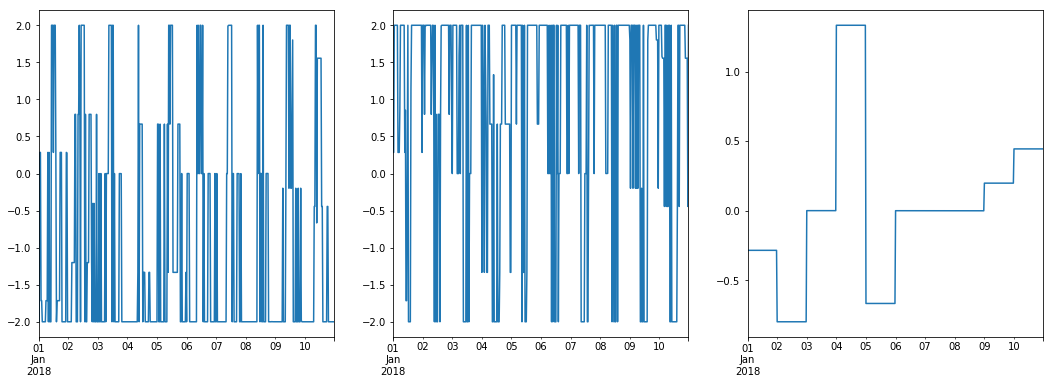

In [13]:
plt.figure(figsize=(18,6))
plt.subplot(131)
output['Market1'].head(10*48).plot()
plt.subplot(132)
output['Market2'].head(10*48).plot()
plt.subplot(133)
output['Market3'].head(10*48).plot()

Variation looks reasonable.

Plot next power in battery, and profit

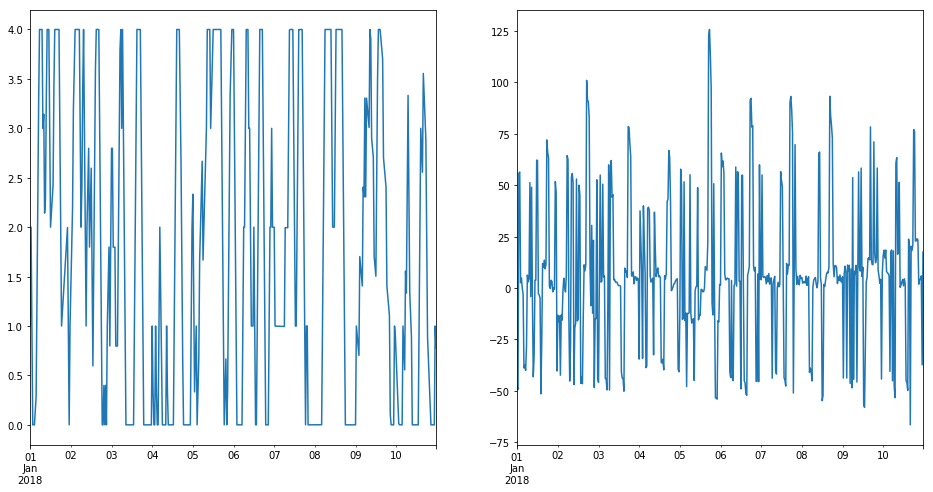

In [14]:
plt.figure(figsize=(16,8))
plt.subplot(121)
output['Charge'].head(10*48).plot()
plt.subplot(122)
output['Profit'].head(10*48).plot()

Both appear within bounds, and look reasonable. 

Are we getting a profit?

In [15]:
output['Cumulative Profit'] = output['Profit'].cumsum()

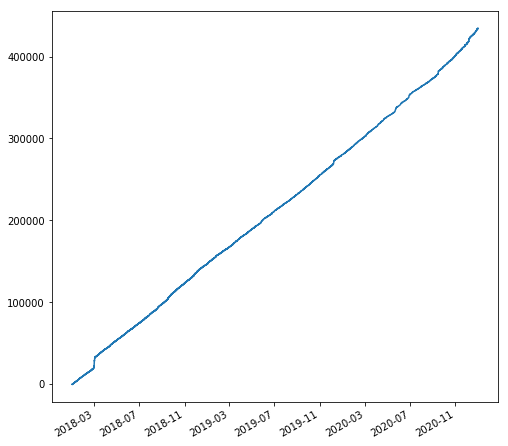

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(111)
output['Cumulative Profit'].plot()

What is the battery charge/discharge?

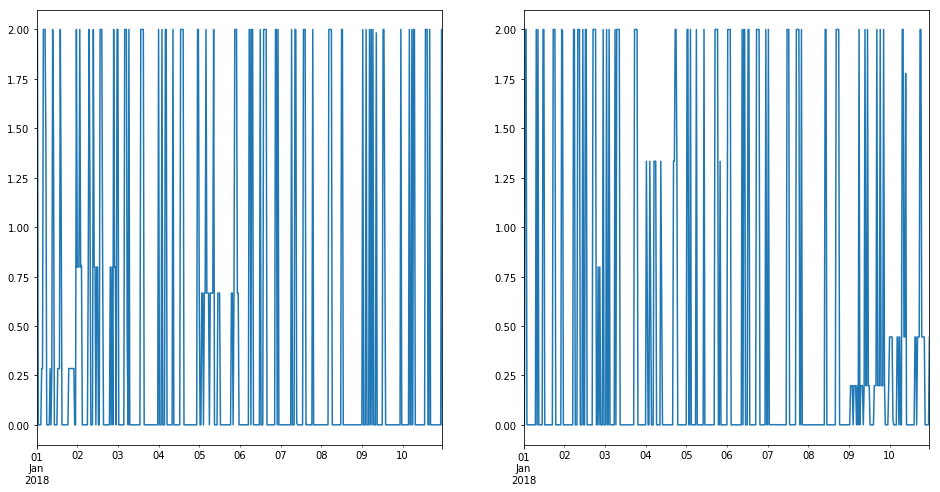

In [17]:
output['Charging'] = -1 * output[['Market1','Market2','Market3']].sum(axis=1).clip(upper = 0) 
output['Discharging'] = output[['Market1','Market2','Market3']].sum(axis=1).clip(lower = 0) 

plt.figure(figsize=(16,8))
plt.subplot(121)
output['Charging'].head(10*48).plot()
plt.subplot(122)
output['Discharging'].head(10*48).plot()

In [18]:
out_xls = pd.ExcelWriter(r'C:\Users\Poul\OneDrive\Desktop\Aurora Excercise\Model Output.xlsx',mode='w')
output.to_excel(out_xls,'Model')

defs = {\
       'Market1':'Power sold to (brought from) Market 1 throughout the interval, in MW. Positive values are power sold, negative are power brought.',\
       'Market2':'Power sold to (brought from) Market 2 throughout the interval, in MW. Positive values are power sold, negative are power brought.',\
       'Market3':'Power sold to (brought from) Market 3 throughout the interval, in MW. Positive values are power sold, negative are power brought.',\
       'Charge':'Charge in the battery at the end of the interval, in MWh',\
       'Profit':'Profit/Loss in the interval, in £.',\
       'Cumulative Profit':'Cumulative profit/loss to the end of the interval.',\
       'Charging':'Rate at which the battery is charging, in MW.',\
       'Discharging':'Rate at which the battery is discharging, in MW.'
      }

out_xls = pd.ExcelWriter(r'C:\Users\Poul\OneDrive\Desktop\Aurora Excercise\Definitions.xlsx',mode='w')
definitions = pd.DataFrame(defs.values(),index=pd.Index(defs.keys()),columns=['Definitions'])
definitions.to_excel(out_xls,'Key')

In [21]:
output.tail()

,Market1,Market2,Market3,Charge,Profit,Cumulative Profit,Charging,Discharging
2020-12-31 21:30:00,-2,1.66666,0.333337,-1.11022e-16,5.21498,434288,-0.000000e+00,1.110223e-16
2020-12-31 22:00:00,-2,1.66666,0.333337,5.55112e-17,3.04,434291,3.330669e-16,0.000000e+00
2020-12-31 22:30:00,-2,1.66666,0.333337,0,5.80333,434297,-0.000000e+00,1.110223e-16
2020-12-31 23:00:00,-2,-0.333337,0.333337,1,-60.5017,434236,2.000000e+00,0.000000e+00
2020-12-31 23:30:00,-0.333337,2,0.333337,0,69.4383,434306,-0.000000e+00,2.000000e+00
